## Fine Tuning of VGG16 for Biofuel Material Cassification

In [ ]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras as kr
from tensorflow.keras.utils import Sequence
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import itertools

%matplotlib inline
%run DataAugmentation.ipynb # 'import' DA notebook [NOTE: THERE ARE GLOBALS DEFINED HERE!]

#### Fetch & Download VGG16 model

In [5]:
vgg16 = kr.applications.vgg16
vgg16_model = vgg16.VGG16(
    include_top=False, 
    weights='imagenet', 
    input_tensor=kr.layers.Input(shape=(224, 224, 3))
)
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### Loading data from a pretrained model (skip if training)
_If running the cell below, skip the build & train phases!_

In [ ]:
model = kr.models.load_model("trained_model")
history = []
model.summary() 

#### Building & Compiling

In [6]:
# Ease of Access
Dropout, Flatten, Dense = kr.layers.Dropout, kr.layers.Flatten, kr.layers.Dense

# Construct the Head Model
head_model = vgg16_model.output
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(512, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

# place the head model on top of the base model (this will become the actual model we will train)
model = kr.models.Model(inputs=vgg16_model.input, outputs=head_model)

# Freeze all the layers
for layer in vgg16_model.layers[:]:
    layer.trainable = False

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### Warmup Training

In [7]:
# Compile Module
model.compile(
    loss='binary_crossentropy',
    optimizer=kr.optimizers.RMSprop(lr=1e-4),
    metrics=['accuracy']
)

# Train the head of the module (Our Layers)
t1_history = model.fit_generator(
    train_set,
    steps_per_epoch=train_set.samples/train_set.batch_size,
    epochs=15,
    validation_data=validation_set,
    validation_steps=validation_set.samples/validation_set.batch_size,
    verbose=1
)

Epoch 1/15
242/241 [==============================] - 128s 528ms/step - loss: 1.9742 - accuracy: 0.8358 - val_loss: 1.6768 - val_accuracy: 0.8715
Epoch 2/15
242/241 [==============================] - 118s 489ms/step - loss: 1.2844 - accuracy: 0.9029 - val_loss: 1.4545 - val_accuracy: 0.8923
Epoch 3/15
242/241 [==============================] - 119s 491ms/step - loss: 0.9091 - accuracy: 0.9266 - val_loss: 1.4222 - val_accuracy: 0.8936
Epoch 4/15
242/241 [==============================] - 119s 490ms/step - loss: 0.8573 - accuracy: 0.9341 - val_loss: 1.6022 - val_accuracy: 0.8771
Epoch 5/15
242/241 [==============================] - 118s 488ms/step - loss: 0.7102 - accuracy: 0.9498 - val_loss: 1.4102 - val_accuracy: 0.8923
Epoch 6/15
242/241 [==============================] - 118s 489ms/step - loss: 0.6051 - accuracy: 0.9548 - val_loss: 1.3842 - val_accuracy: 0.8895
Epoch 7/15
242/241 [==============================] - 119s 490ms/step - loss: 0.5014 - accuracy: 0.9623 - val_loss: 1.3829 -

In [10]:
model.save("warmedupModel")

INFO:tensorflow:Assets written to: warmedupModel\assets


#### Final Training

In [9]:
# Reset validaiton & train set generators
train_set.reset()
validation_set.reset()

# Now that the head FC layers have been trained/initialized, lets
# Unfreeze the final set of CONV layers and make them trainable
for layer in vgg16_model.layers[15:]:
	layer.trainable = True

    
# Recompile module for changes to take effect, now using SGD with very small learning rate
model.compile(
    loss="binary_crossentropy", 
    optimizer=kr.optimizers.RMSprop(lr=1e-4), 
    metrics=["accuracy"]
)    

# Train the whole module
t2_history = model.fit_generator(
    train_set,
    steps_per_epoch=train_set.samples/train_set.batch_size,
    epochs=10,
    validation_data=validation_set,
    validation_steps=validation_set.samples/validation_set.batch_size,
    verbose=1
)

Epoch 1/10
242/241 [==============================] - 116s 479ms/step - loss: 3.1163 - accuracy: 0.7893 - val_loss: 3.1135 - val_accuracy: 0.7859
Epoch 2/10
242/241 [==============================] - 118s 488ms/step - loss: 4.3377 - accuracy: 0.7142 - val_loss: 2.8698 - val_accuracy: 0.8108
Epoch 3/10
242/241 [==============================] - 120s 496ms/step - loss: 3.0413 - accuracy: 0.7997 - val_loss: 2.4700 - val_accuracy: 0.8384
Epoch 4/10
242/241 [==============================] - 121s 500ms/step - loss: 2.6396 - accuracy: 0.8233 - val_loss: 6.7778 - val_accuracy: 0.5580
Epoch 5/10
242/241 [==============================] - 117s 484ms/step - loss: 2.7667 - accuracy: 0.8154 - val_loss: 2.7072 - val_accuracy: 0.8232
Epoch 6/10
242/241 [==============================] - 116s 479ms/step - loss: 2.7059 - accuracy: 0.8225 - val_loss: 2.6919 - val_accuracy: 0.8260
Epoch 7/10
242/241 [==============================] - 119s 491ms/step - loss: 3.2857 - accuracy: 0.7835 - val_loss: 5.2688 -

#### Visualising Training Data

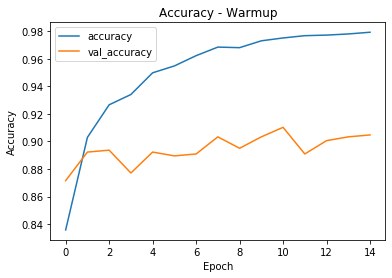

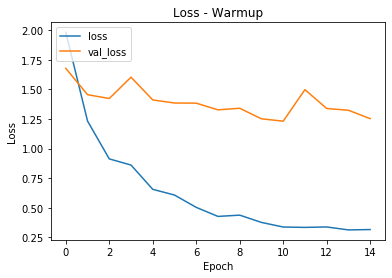

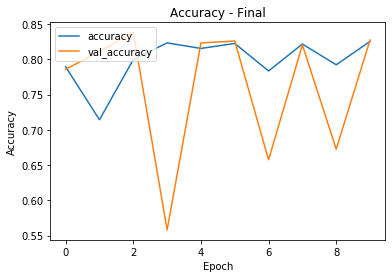

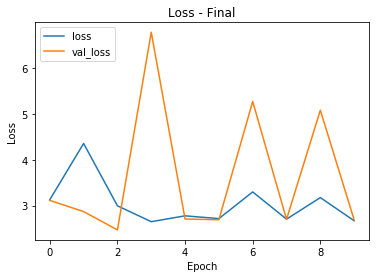

In [22]:
t1_history.plot_title = "Warmup"
t2_history.plot_title = "Final"

global_history = [t1_history, t2_history]

for history in global_history:
    # summarize history for accuracy
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title("Accuracy - " + history.plot_title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title("Loss - " + history.plot_title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
plt

#### Making Predictions & Visualising Output

In [12]:
predictions = model.predict_generator(test_set, steps=1, verbose=1)
_, test_labels = next(test_set)

# get predictions for the test set
for i in range(len(test_set)-1):
    predictions = np.concatenate((predictions,model.predict_generator(test_set, steps=1, verbose=1)))
    _,temp = next(test_set)
    test_labels = np.concatenate((test_labels,temp))

# get labels from the test set
def ReformatData(y):
    x = np.copy(y[:,0])
    for i in range(len(x)):
        if x[i]>=0.5 or x[i] == True:
            x[i]=1
        else:
            x[i]=0
    x.astype(int)        
    return x
                
cut_predictions = ReformatData(predictions)
cut_labels = ReformatData(test_labels)

print("Cut predictions:",cut_predictions)
print("Cut labels:",cut_labels)
print("Unique labels:",unique_labels(cut_predictions,cut_labels))

1/1 [==============================] - 0s 428ms/step
Cut predictions: [0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Cut labels: [1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 

In [13]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ["non_biofuel","biofuel"]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, abs(i-0.25), format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    fig.tight_layout()
    return ax

Normalized confusion matrix


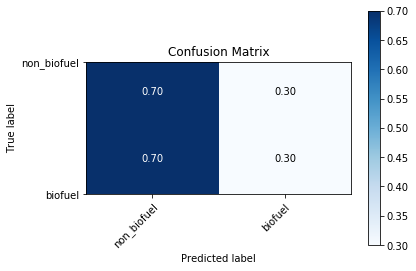

In [14]:
# Plot confusion matrix based on predictions of our test data set
plot_confusion_matrix(cut_labels, cut_predictions, ['biomass', 'non_biomass'], title='Confusion Matrix', normalize=True)

### ----------------- Cells Below Are for Testing Purposes ----------------- 

In [ ]:
####### DONT RUN - THIS IS FOR TESTING PURPOSES ########

# load the model
test_vgg16 = kr.applications.vgg16
test_model = test_vgg16.VGG16()
# load an image from file
test_image = kr.preprocessing.image.load_img('dataset/train/biomass/cardboard189.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
test_image = kr.preprocessing.image.img_to_array(test_image)
# reshape data for the model
test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
# prepare the image for the VGG model
test_image = test_vgg16.preprocess_input(test_image)
# predict the probability across all output classes
yhat = test_model.predict(test_image)
# convert the probabilities to class labels
tesT_label = test_vgg16.decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
test_label = test_label[0][0]
# print the classification
print('%s (%.2f%%)' % (test_label[1], test_label[2]*100))